# Maternal Health Risk Score Calculator



In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load datasets
clinical = pd.read_csv('Maternal_HealthRisk.csv')
nfhs = pd.read_csv('NFHS_Factsheet.csv')
life = pd.read_csv('Lifestyle_Dataset.csv')

clinical.head()


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [4]:
# Detect target
target=None
for c in clinical.columns:
    if c.lower() in ['risk','risklevel','risk_level']:
        target=c
        break
if target is None:
    target=clinical.columns[-1]

print("Target:",target)


Target: RiskLevel


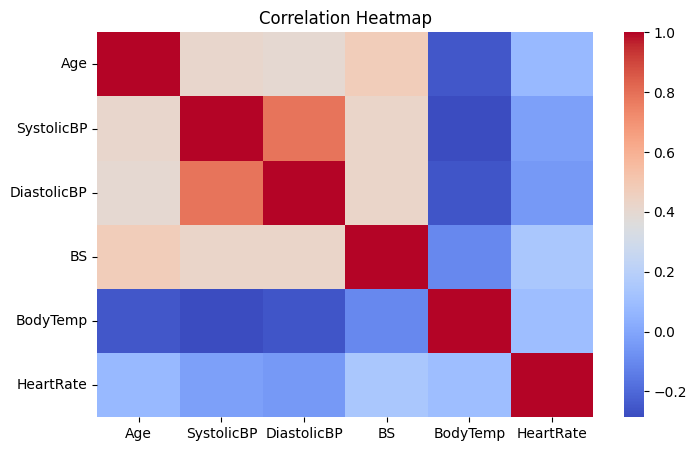

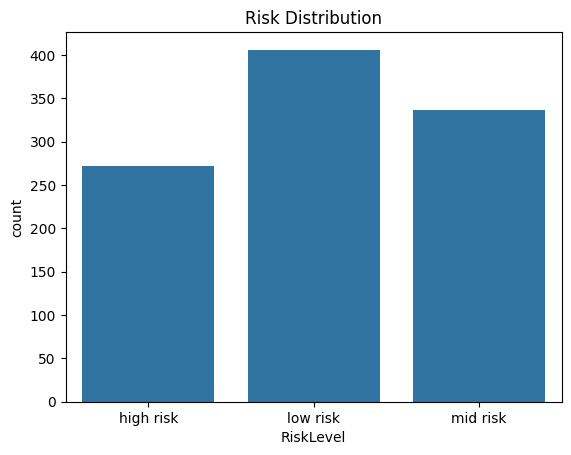

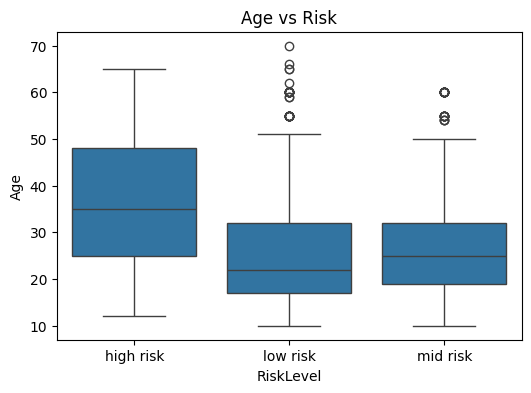

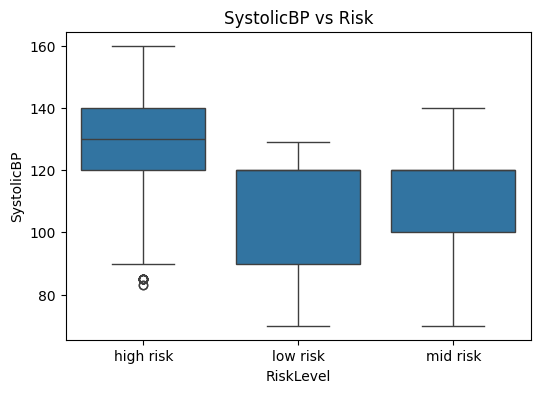

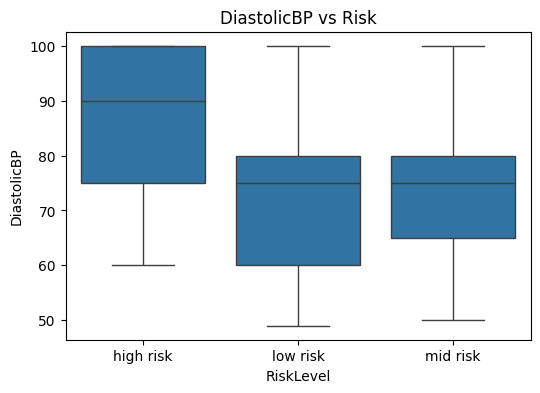

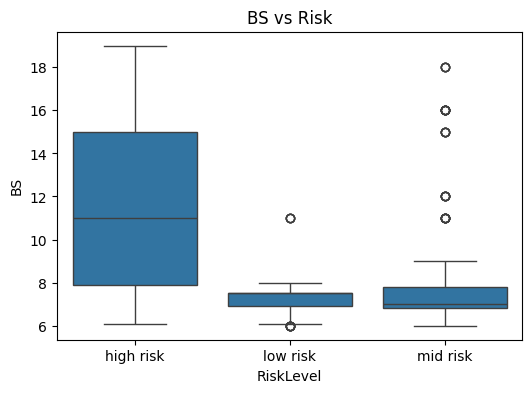

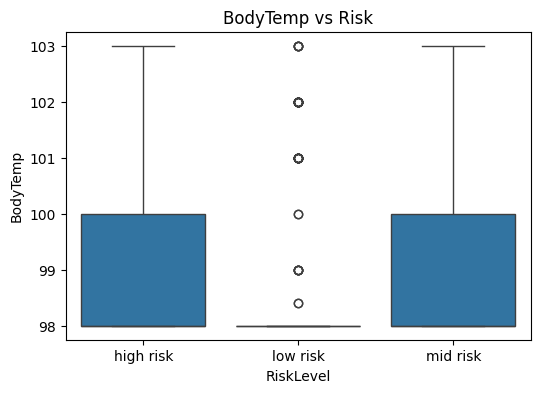

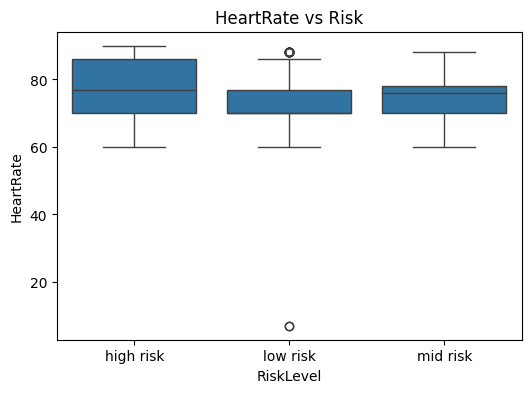

In [5]:
# EDA 
num_cols = clinical.select_dtypes(include=np.number).columns

plt.figure(figsize=(8,5))
sns.heatmap(clinical[num_cols].corr(),cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

sns.countplot(data=clinical,x=target)
plt.title("Risk Distribution")
plt.show()

for col in num_cols[:6]:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=clinical,x=target,y=col)
    plt.title(f"{col} vs Risk")
    plt.show()


In [6]:
# Preprocessing Clinical
df = clinical.copy()
y = df[target]
X = df.drop(columns=[target])

# Encode categoricals
for c in X.select_dtypes('object').columns:
    X[c] = LabelEncoder().fit_transform(X[c].astype(str))

# Impute
imp = SimpleImputer(strategy='median')
X[X.columns] = imp.fit_transform(X)

# Encode target
if y.dtype=='object':
    y = LabelEncoder().fit_transform(y)


In [7]:
# Define Models
rf = RandomForestClassifier(random_state=42)
xgb_clf = xgb.XGBClassifier(eval_metric='logloss',random_state=42)
lgb_clf = lgb.LGBMClassifier(random_state=42)
lasso = LogisticRegression(penalty='l1',solver='liblinear')

models = {
    "RF": rf,
    "XGB": xgb_clf,
    "LGBM": lgb_clf,
    "LASSO": lasso
}

kf=KFold(n_splits=5,shuffle=True,random_state=42)
for name,m in models.items():
    scores=cross_val_score(m,X,y,cv=kf,scoring='roc_auc')
    print(name,"ROC-AUC:",scores.mean())


RF ROC-AUC: nan
XGB ROC-AUC: nan
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 811, number of used features: 6
[LightGBM] [Info] Start training from score -1.282168
[LightGBM] [Info] Start training from score -0.911371
[LightGBM] [Info] Start training from score -1.137586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [8]:
# Stacking (Final Model)
stack = StackingClassifier(
    estimators=[
        ("xgb",xgb_clf),
        ("lgb",lgb_clf),
        ("rf",rf)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

stack.fit(X_train,y_train)

pred = stack.predict(X_test)
proba = stack.predict_proba(X_test)[:,1]

print("Accuracy:",accuracy_score(y_test,pred))
roc_auc_score(y_test, stack.predict_proba(X_test), multi_class='ovr')
print(classification_report(y_test,pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 811, number of used features: 6
[LightGBM] [Info] Start training from score -1.318371
[LightGBM] [Info] Start training from score -0.914443
[LightGBM] [Info] Start training from score -1.103557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [9]:
#SAVE MODEL
save_path = "stacking_model.joblib"
joblib.dump(stack, save_path)

print("\nModel saved successfully at:")
print(save_path)


Model saved successfully at:
stacking_model.joblib


In [10]:
# NFHS SCORING 

def safe_float(x):
    try:
        v = float(x)
        return v
    except:
        return None


def nfhs_score_v2(row):
    score = 0

    # High-risk indicators
    bad_cols = [
        'Ever-married women age 18-49 years who have ever experienced spousal violence27 (%)',
        'Ever-married women age 18-49 years who have experienced physical violence during any pregnancy (%)',
        'Young women age 18-29 years who experienced sexual violence by age 18 (%)',
        'Women age 15 years and above who use any kind of tobacco (%)',
        'Men age 15 years and above who use any kind of tobacco (%)',
        'Women age 15 years and above who consume alcohol (%)',
        'Men age 15 years and above who consume alcohol (%)'
    ]

    for col in bad_cols:
        if col in row.index:
            val = safe_float(row[col])
            if val is not None:  # only score real numbers
                score += np.interp(val, [0, 40], [0, 12/len(bad_cols)])


    # Protective indicators
    good_cols = [
        'Female population age 6 years and above who ever attended school (%)',
        'Women (age 15-49 years) having a bank or savings account that they themselves use (%)',
        'Women (age 15-49 years) having a mobile phone that they themselves use (%)',
        'Population living in households with an improved drinking-water source1 (%)',
        'Population living in households that use an improved sanitation facility2 (%)',
        'Households using clean fuel for cooking3 (%)'
    ]

    reduction = 0
    for col in good_cols:
        if col in row.index:
            val = safe_float(row[col])
            if val is not None:
                reduction += np.interp(val, [40, 100], [4/len(good_cols), 0])

    final = max(score - reduction, 0)
    return round(min(final, 20), 2)


In [11]:
# LIFESTYLE SCORING

life_cols = {c.lower(): c for c in life.columns}

col_sleep = life_cols.get('sleep duration')
col_stress = life_cols.get('stress level')
col_hydr = life_cols.get('hydration')
col_act = life_cols.get('physical activity level')

def lifestyle_score(rec):
    s = 0
    rec_lower = {k.lower(): v for k, v in rec.items()}   # <-- FIX

    # Sleep
    if 'sleep duration' in rec_lower:
        h = float(rec_lower['sleep duration'])
        if h < 5: s += 8
        elif h < 6: s += 6
        elif h < 7: s += 3
        elif h > 9: s += 2

    # Stress
    if 'stress level' in rec_lower:
        s += np.interp(float(rec_lower['stress level']), [1, 10], [0, 8])

    # Hydration (if present)
    if 'hydration' in rec_lower:
        s += np.interp(float(rec_lower['hydration']), [3.0, 0.5], [0, 4])

    # Activity (if present)
    if 'physical activity level' in rec_lower:
        s += np.interp(float(rec_lower['physical activity level']), [120, 0], [0, 4])

    return round(min(s, 20), 2)


In [12]:
#  RISK CALCULATOR 

def final_risk(clinical_input, lifestyle_input, nfhs_row=None):
    # 1. Prepare clinical input
    x = pd.DataFrame([clinical_input])
    for c in X.columns:
        if c not in x.columns:
            x[c] = 0
    x = x[X.columns]

    # 2. ML Score (0–60)
    try:
        ml_prob = float(stack.predict_proba(x)[0][1])
    except:
        ml_prob = float(stack.predict(x)[0])

    ml_score = ml_prob * 60

    # 3. NFHS Score (0–20)
    if nfhs_row is None:
        nfhs_row = nfhs.iloc[0]   # Default: first NFHS region

    nfhs_s = nfhs_score_v2(nfhs_row)

    # 4. Lifestyle Score (0–20)
    life_s = lifestyle_score(lifestyle_input)

    # 5. FINAL SCORE (0–100)
    total = ml_score + nfhs_s + life_s
    total = min(max(total, 0), 100)

    if total <= 30:
        cat = "Low"
    elif total <= 60:
        cat = "Moderate"
    else:
        cat = "High"

    return {
        "Final Score": round(total, 2),
        "Category": cat,
        "ML Score": round(ml_score, 2),
        "NFHS Score": nfhs_s,
        "Lifestyle Score": life_s,
        "ML Probability": round(ml_prob, 3)
    }


In [13]:
#BALANCED RANDOM TEST GENERATOR 

import random
import numpy as np

def generate_clinical_case(level="low"):
    """Generate clinical vitals for low, moderate or high risk groups."""
    if level == "low":
        return {
            "Age": random.randint(18, 28),          # younger
            "SystolicBP": random.randint(90, 120),  # normal BP
            "HeartRate": random.randint(70, 95),    # normal HR
        }

    elif level == "moderate":
        return {
            "Age": random.randint(28, 35),
            "SystolicBP": random.randint(120, 140), 
            "HeartRate": random.randint(90, 115),
        }

    else:  # high-risk
        return {
            "Age": random.randint(35, 45),
            "SystolicBP": random.randint(140, 165),     # hypertension
            "HeartRate": random.randint(115, 145),      # tachycardia
        }


def generate_lifestyle_case(level="low"):
    """Balanced lifestyle generators."""
    if level == "low":
        return {
            "sleep duration": random.uniform(6.5, 9),
            "stress level": random.randint(1, 4),
            "hydration": random.uniform(1.5, 3.0),
            "physical activity level": random.randint(60, 120),
        }

    elif level == "moderate":
        return {
            "sleep duration": random.uniform(5, 7),
            "stress level": random.randint(4, 7),
            "hydration": random.uniform(1.0, 2.5),
            "physical activity level": random.randint(30, 90),
        }

    else:  # high-risk
        return {
            "sleep duration": random.uniform(3, 5),
            "stress level": random.randint(7, 10),
            "hydration": random.uniform(0.5, 1.2),
            "physical activity level": random.randint(0, 40),
        }


def random_test_balanced(n=10):
    results = []

    for _ in range(n):
        # randomly pick low/moderate/high group
        level = random.choice(["low", "moderate", "high"])

        # generate clinical data
        clin = generate_clinical_case(level)

        # generate lifestyle data
        life_rec = generate_lifestyle_case(level)

        # pick a random NFHS row
        nfhs_row = nfhs.sample(1).iloc[0]

        # compute final risk
        res = final_risk(clin, life_rec, nfhs_row)
        res["Group"] = level   
        results.append(res)

    return results


# --- RUN DEMO ---
random_test_balanced(10)


[{'Final Score': np.float64(24.61),
  'Category': 'Low',
  'ML Score': 6.58,
  'NFHS Score': np.float64(1.36),
  'Lifestyle Score': np.float64(16.67),
  'ML Probability': 0.11,
  'Group': 'moderate'},
 {'Final Score': np.float64(31.29),
  'Category': 'Moderate',
  'ML Score': 11.11,
  'NFHS Score': np.float64(2.62),
  'Lifestyle Score': np.float64(17.56),
  'ML Probability': 0.185,
  'Group': 'moderate'},
 {'Final Score': np.float64(28.64),
  'Category': 'Low',
  'ML Score': 6.11,
  'NFHS Score': np.float64(2.53),
  'Lifestyle Score': 20,
  'ML Probability': 0.102,
  'Group': 'high'},
 {'Final Score': 26.42,
  'Category': 'Low',
  'ML Score': 6.42,
  'NFHS Score': 0,
  'Lifestyle Score': 20,
  'ML Probability': 0.107,
  'Group': 'high'},
 {'Final Score': np.float64(70.67),
  'Category': 'High',
  'ML Score': 51.9,
  'NFHS Score': np.float64(2.1),
  'Lifestyle Score': np.float64(16.67),
  'ML Probability': 0.865,
  'Group': 'moderate'},
 {'Final Score': np.float64(26.02),
  'Category': 